<a href="https://colab.research.google.com/github/mjdall/pinterest_scraper/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
effecient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
transfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning
classification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
"""

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os

os.chdir("/content/drive/MyDrive/pinterest_scraper/")

In [63]:
import pandas as pd

image_locs = pd.read_csv("data/image_reference.csv")
image_locs.sample(5)

,Unnamed: 0,label,file_location,group_id
2624,2624,Interior design,data/interior_design/d1ec19f56fe80cbdf32defb01...,417
4617,4617,Starbucks drinks,data/starbucks_drinks/eff922cdaa873cdf4c975804...,410
5141,5141,Tattoo sketches,data/tattoo_sketches/db324878adff3682f7f038dc9...,442
549,549,Bullet journal,data/bullet_journal/55ee677c180e4610a6ba9d0769...,342
1379,1379,Food porn,data/food_porn/e2efeb73bbc5e4474cd7821f4e51674...,172


In [64]:
def get_group(group_id, training_ids, testing_ids):
  if group_id in training_ids:
    return("training")
  elif group_id in testing_ids:
    return("testing")
  else:
    return("validation")

In [88]:
import math
import numpy as np

TRAINING_SIZE = .7

available_labels = image_locs.label.unique()

for label in available_labels:
  label_subset = image_locs[image_locs.label == label]
  group_ids = label_subset.group_id.reset_index(drop=True)

  # get train/test/validation ids
  training_ids = group_ids.sample(frac=TRAINING_SIZE)
  remaining_ids = group_ids[~group_ids.isin(training_ids)]
  testing_ids = remaining_ids.sample(frac=.5)

  # make a lambda to apply
  alloc_lmbda = lambda gid: get_group(gid, training_ids, testing_ids)

  # write the split allocation to the df
  image_locs.loc[label_subset.index, "split"] = label_subset.group_id.apply(alloc_lmbda)

image_locs

,Unnamed: 0,label,file_location,group_id,split
0,0,90s fashion men,data/90s_fashion_men/cfaf965d69f685d8e69956ba7...,0,training
1,1,90s fashion men,data/90s_fashion_men/fa6f7f62186191520d17ec3df...,1,training
2,2,90s fashion men,data/90s_fashion_men/d9cb8bce7608cf99e01f24c98...,2,training
3,3,90s fashion men,data/90s_fashion_men/680414f948622b0203c1b0056...,3,testing
4,4,90s fashion men,data/90s_fashion_men/f0cba34dd73764ef7b9962527...,4,training
...,...,...,...,...,...
5694,5694,White aesthetic,data/white_aesthetic/448946d180a5f9d9df8cbcf76...,495,training
5695,5695,White aesthetic,data/white_aesthetic/ea64d4023642884c808f6c7e7...,496,training
5696,5696,White aesthetic,data/white_aesthetic/79b0856002598d613564b80eb...,497,training
5697,5697,White aesthetic,data/white_aesthetic/7f2ec49fdd6c5928ddad23a87...,498,validation


In [89]:
image_locs.groupby("label").split.value_counts()

label                      split     
90s fashion men            training      145
                           testing        31
                           validation     31
Bullet journal             training      350
                           testing        75
                           validation     75
Easy drawings              training      350
                           testing        75
                           validation     75
Food porn                  training      350
                           testing        75
                           validation     75
Forearm tattoos            training      350
                           testing        75
                           validation     75
Interior design            training      350
                           testing        75
                           validation     75
Mens clothing styles       training      350
                           testing        75
                           validation     75
Modern farmhouse 

In [97]:
IMG_SIZE = 224
BATCH_SIZE = 64
DATASET_NAME = "pinterest"
NUM_CLASSES = image_locs.label.nunique()

SIZE = (IMG_SIZE, IMG_SIZE)

In [90]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset = image_dataset_from_directory("data", label_mode="categorical")

dataset

Found 5699 files belonging to 12 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>

In [98]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


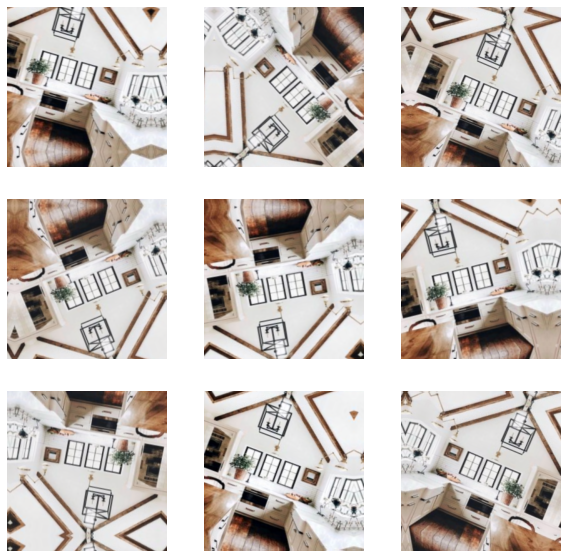

In [99]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

for image, _ in dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [93]:
effecientnetb0 = tf.keras.applications.EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights="imagenet")

In [94]:
image_batch, label_batch = next(iter(dataset))
feature_batch = effecientnetb0(image_batch)

print(feature_batch.shape)

(32, 8, 8, 1280)


In [95]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [96]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 12)


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
